In [1]:
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
import random

In [2]:
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import random


class WarehouseRobotEnvironment(gym.Env):

    def __init__(self, environment_type, max_timesteps=300, max_tasks=1):
        """Initializes the environment with truncation and termination logic."""
        self.environment_type = environment_type
        self.max_timesteps = max_timesteps  # Max timesteps before truncation
        self.max_tasks = max_tasks  # Max tasks to complete per episode

        # Environment dimensions (6x6 grid)
        self.environment_width = 6
        self.environment_height = 6

        # Define action and observation spaces
        self.action_space = spaces.Discrete(6)  # 6 actions (Up, Down, Left, Right, Pick-up, Drop-off)
        # Observation space: [Grid Location, Is Agent Carrying an Item?]
        self.observation_space = spaces.Tuple((spaces.Discrete(self.environment_width * self.environment_height), spaces.Discrete(2)))

        # Obstacles (static shelves)
        self.obstacles = [(1, 1), (3, 3), (2, 4)]

        # Drop-off location
        self.dropoff_location = np.asarray([4, 4])


        self.pickup_location = np.asarray([2,2])

        # Robot's starting position
        self.robot_pos = np.asarray([0, 0])

        # Initialize whether the robot is holding an item or not
        self.holding_item = False

        # Initialize cumulative reward
        self.cumulative_reward = 0

        # Task counter
        self.tasks_completed = 0

        # Timestep counter
        self.timestep = 0

        # Reset the environment
        self.reset()




    def reset(self):
      """Resets the environment and places the robot in the initial state."""
      self.robot_pos = np.asarray([0, 0])  # Reset to the starting position
      self.holding_item = False  # Robot is not holding an item initially
      self.cumulative_reward = 0  # Reset cumulative reward
      self.tasks_completed = 0  # Reset task counter
      self.timestep = 0  # Reset timestep counter

      # One-hot encode the grid location and return it with the holding item status
      return np.concatenate([self._one_hot_encode(self._get_grid_location()), [int(self.holding_item)]])  # Return the initial observation



    def _one_hot_encode(self, location):
        """Converts the grid location to a one-hot encoded vector."""
        one_hot = np.zeros(self.environment_width * self.environment_height)
        one_hot[location] = 1
        return one_hot


    def _get_grid_location(self):
        """Maps the robot's position to a single integer representing the grid location."""
        return self.robot_pos[0] * self.environment_width + self.robot_pos[1]

    def step(self, action):
        """Defines the robot's actions and the environment dynamics."""
        reward = -1  # Penalty for every step to encourage faster task completion
        self.timestep += 1

        # Define the movement actions
        next_pos = np.copy(self.robot_pos)

        if action == 0 and self.robot_pos[1] < self.environment_height - 1:  # Down
            next_pos[1] += 1
        elif action == 1 and self.robot_pos[1] > 0:  # Up
            next_pos[1] -= 1
        elif action == 2 and self.robot_pos[0] > 0:  # Left
            next_pos[0] -= 1
        elif action == 3 and self.robot_pos[0] < self.environment_width - 1:  # Right
            next_pos[0] += 1
        elif action == 4:  # Pick-up
            if np.array_equal(self.robot_pos, self.pickup_location) and not self.holding_item:
                self.holding_item = True
                reward = 10  # Reward for picking up the item
            else:
                reward = -5
        elif action == 5:  # Drop-off
            if np.array_equal(self.robot_pos, self.dropoff_location) and self.holding_item:
                reward = 20  # Increased reward for successful delivery
                self.holding_item = False
                self.tasks_completed += 1

                # Termination condition: terminate only when the task is completed
                terminated = True
                truncated = False  # Make sure truncated is a boolean
                return np.concatenate([self._one_hot_encode(self._get_grid_location()), [int(self.holding_item)]]), reward, terminated, truncated

            else:
                reward = -5  # Reduced penalty for invalid drop-off action

        # Check if the new position hits an obstacle
        if tuple(next_pos) in self.obstacles:
            reward = -20

        # Update the robot's position
        self.robot_pos = next_pos

        if self.environment_type == 'stochastic':
            if random.random() < 0.1:  # 10% chance to stay in place
                self.robot_pos = next_pos  # Remain in the same spot

        # Update cumulative reward
        self.cumulative_reward += reward

        # Truncation condition: if the agent goes out of bounds, truncate
        if not (0 <= self.robot_pos[0] < self.environment_width and 0 <= self.robot_pos[1] < self.environment_height):
            truncated = True
            terminated = False
            return np.concatenate([self._one_hot_encode(self._get_grid_location()), [int(self.holding_item)]]), reward, terminated, truncated

        # Termination condition: End the episode if the max timesteps are exceeded
        terminated = self.timestep >= self.max_timesteps
        truncated = False  # No truncation unless specified

        return np.concatenate([self._one_hot_encode(self._get_grid_location()), [int(self.holding_item)]]), reward, terminated, truncated


    def render(self, mode='human', plot=False):
        """This method renders the environment visually using colored blocks."""
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xticks(np.arange(1, self.environment_width, 1))
        ax.set_yticks(np.arange(1, self.environment_height, 1))
        ax.grid(True)

        # Plot the environment using colored blocks with text labels
        for x in range(self.environment_width):
            for y in range(self.environment_height):
                color = "white"
                text = ""

                # Check for obstacles (represented by red blocks with "NF")
                if (x, y) in self.obstacles:
                    color = "red"
                    text = "Obstacle"

                # Check if the current cell is the pickup location
                elif np.array_equal([x, y], self.pickup_location):
                    color = "green"
                    text = "Pick"

                # Check if the current cell is the drop-off location
                elif np.array_equal([x, y], self.dropoff_location):
                    color = "yellow"
                    text = "Drop"

                # Check if the current cell is the robot's position
                elif np.array_equal([x, y], self.robot_pos):
                    color = "blue"
                    text = "Robo" if not self.holding_item else "R (Carrying)"

                # Draw the block with its respective color
                ax.add_patch(plt.Rectangle((x, y), 1, 1, color=color))

                # Add the text in the center of the block
                ax.text(x + 0.5, y + 0.5, text, ha='center', va='center', fontsize=10)

        # Display the cumulative reward and task status
        plt.title(f"Cumulative Reward: {self.cumulative_reward} | Tasks Completed: {self.tasks_completed}/{self.max_tasks}")
        plt.xlim(0, self.environment_width)
        plt.ylim(0, self.environment_height)
        plt.gca().invert_yaxis()  # Invert the Y-axis to match grid layout
        plt.show()
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import random


class WarehouseRobotEnvironment(gym.Env):

    def __init__(self, environment_type, max_timesteps=300, max_tasks=1):
        """Initializes the environment with truncation and termination logic."""
        self.environment_type = environment_type
        self.max_timesteps = max_timesteps  # Max timesteps before truncation
        self.max_tasks = max_tasks  # Max tasks to complete per episode

        # Environment dimensions (6x6 grid)
        self.environment_width = 6
        self.environment_height = 6

        # Define action and observation spaces
        self.action_space = spaces.Discrete(6)  # 6 actions (Up, Down, Left, Right, Pick-up, Drop-off)
        # Observation space: [Grid Location, Is Agent Carrying an Item?]
        self.observation_space = spaces.Tuple((spaces.Discrete(self.environment_width * self.environment_height), spaces.Discrete(2)))

        # Obstacles (static shelves)
        self.obstacles = [(1, 1), (3, 3), (2, 4)]

        # Drop-off location
        self.dropoff_location = np.asarray([4, 4])


        self.pickup_location = np.asarray([2,2])

        # Robot's starting position
        self.robot_pos = np.asarray([0, 0])

        # Initialize whether the robot is holding an item or not
        self.holding_item = False

        # Initialize cumulative reward
        self.cumulative_reward = 0

        # Task counter
        self.tasks_completed = 0

        # Timestep counter
        self.timestep = 0

        # Reset the environment
        self.reset()




    def reset(self):
      """Resets the environment and places the robot in the initial state."""
      self.robot_pos = np.asarray([0, 0])  # Reset to the starting position
      self.holding_item = False  # Robot is not holding an item initially
      self.cumulative_reward = 0  # Reset cumulative reward
      self.tasks_completed = 0  # Reset task counter
      self.timestep = 0  # Reset timestep counter

      # One-hot encode the grid location and return it with the holding item status
      return np.concatenate([self._one_hot_encode(self._get_grid_location()), [int(self.holding_item)]])  # Return the initial observation



    def _one_hot_encode(self, location):
        """Converts the grid location to a one-hot encoded vector."""
        one_hot = np.zeros(self.environment_width * self.environment_height)
        one_hot[location] = 1
        return one_hot


    def _get_grid_location(self):
        """Maps the robot's position to a single integer representing the grid location."""
        return self.robot_pos[0] * self.environment_width + self.robot_pos[1]

    def step(self, action):
        """Defines the robot's actions and the environment dynamics."""
        reward = -1  # Penalty for every step to encourage faster task completion
        self.timestep += 1

        # Define the movement actions
        next_pos = np.copy(self.robot_pos)

        if action == 0 and self.robot_pos[1] < self.environment_height - 1:  # Down
            next_pos[1] += 1
        elif action == 1 and self.robot_pos[1] > 0:  # Up
            next_pos[1] -= 1
        elif action == 2 and self.robot_pos[0] > 0:  # Left
            next_pos[0] -= 1
        elif action == 3 and self.robot_pos[0] < self.environment_width - 1:  # Right
            next_pos[0] += 1
        elif action == 4:  # Pick-up
            if np.array_equal(self.robot_pos, self.pickup_location) and not self.holding_item:
                self.holding_item = True
                reward = 10  # Reward for picking up the item
            else:
                reward = -5
        elif action == 5:  # Drop-off
            if np.array_equal(self.robot_pos, self.dropoff_location) and self.holding_item:
                reward = 20  # Increased reward for successful delivery
                self.holding_item = False
                self.tasks_completed += 1

                # Termination condition: terminate only when the task is completed
                terminated = True
                truncated = False  # Make sure truncated is a boolean
                return np.concatenate([self._one_hot_encode(self._get_grid_location()), [int(self.holding_item)]]), reward, terminated, truncated

            else:
                reward = -5  # Reduced penalty for invalid drop-off action

        # Check if the new position hits an obstacle
        if tuple(next_pos) in self.obstacles:
            reward = -20

        # Update the robot's position
        self.robot_pos = next_pos

        if self.environment_type == 'stochastic':
            if random.random() < 0.1:  # 10% chance to stay in place
                self.robot_pos = next_pos  # Remain in the same spot

        # Update cumulative reward
        self.cumulative_reward += reward

        # Truncation condition: if the agent goes out of bounds, truncate
        if not (0 <= self.robot_pos[0] < self.environment_width and 0 <= self.robot_pos[1] < self.environment_height):
            truncated = True
            terminated = False
            return np.concatenate([self._one_hot_encode(self._get_grid_location()), [int(self.holding_item)]]), reward, terminated, truncated

        # Termination condition: End the episode if the max timesteps are exceeded
        terminated = True if self.timestep >= self.max_timesteps else False
        truncated = False  # Ensure truncated is False when the episode is not truncated

        return np.concatenate([self._one_hot_encode(self._get_grid_location()), [int(self.holding_item)]]), reward, terminated, truncated


    def render(self, mode='human', plot=False):
        """This method renders the environment visually using colored blocks."""
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xticks(np.arange(1, self.environment_width, 1))
        ax.set_yticks(np.arange(1, self.environment_height, 1))
        ax.grid(True)

        # Plot the environment using colored blocks with text labels
        for x in range(self.environment_width):
            for y in range(self.environment_height):
                color = "white"
                text = ""

                # Check for obstacles (represented by red blocks with "NF")
                if (x, y) in self.obstacles:
                    color = "red"
                    text = "Obstacle"

                # Check if the current cell is the pickup location
                elif np.array_equal([x, y], self.pickup_location):
                    color = "green"
                    text = "Pick"

                # Check if the current cell is the drop-off location
                elif np.array_equal([x, y], self.dropoff_location):
                    color = "yellow"
                    text = "Drop"

                # Check if the current cell is the robot's position
                elif np.array_equal([x, y], self.robot_pos):
                    color = "blue"
                    text = "Robo" if not self.holding_item else "R (Carrying)"

                # Draw the block with its respective color
                ax.add_patch(plt.Rectangle((x, y), 1, 1, color=color))

                # Add the text in the center of the block
                ax.text(x + 0.5, y + 0.5, text, ha='center', va='center', fontsize=10)

        # Display the cumulative reward and task status
        plt.title(f"Cumulative Reward: {self.cumulative_reward} | Tasks Completed: {self.tasks_completed}/{self.max_tasks}")
        plt.xlim(0, self.environment_width)
        plt.ylim(0, self.environment_height)
        plt.gca().invert_yaxis()  # Invert the Y-axis to match grid layout
        plt.show()


Episode 0 - Total Reward: -1216, Epsilon: 0.995, Done: True, Truncated: False
Episode 1 - Total Reward: -1003, Epsilon: 0.990025, Done: True, Truncated: False
Episode 2 - Total Reward: -88, Epsilon: 0.985074875, Done: True, Truncated: False
Episode 3 - Total Reward: -1172, Epsilon: 0.9801495006250001, Done: True, Truncated: False
Episode 4 - Total Reward: -1207, Epsilon: 0.9752487531218751, Done: True, Truncated: False
Episode 5 - Total Reward: -966, Epsilon: 0.9703725093562657, Done: True, Truncated: False
Episode 6 - Total Reward: -951, Epsilon: 0.9655206468094844, Done: True, Truncated: False
Episode 7 - Total Reward: -964, Epsilon: 0.960693043575437, Done: True, Truncated: False
Episode 8 - Total Reward: -241, Epsilon: 0.9558895783575597, Done: True, Truncated: False
Episode 9 - Total Reward: -1489, Epsilon: 0.9511101304657719, Done: True, Truncated: False
Episode 10 - Total Reward: -1096, Epsilon: 0.946354579813443, Done: True, Truncated: False
Episode 11 - Total Reward: -1199, Ep

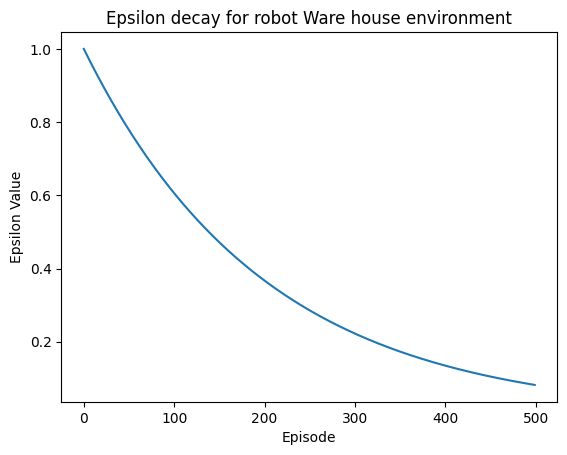

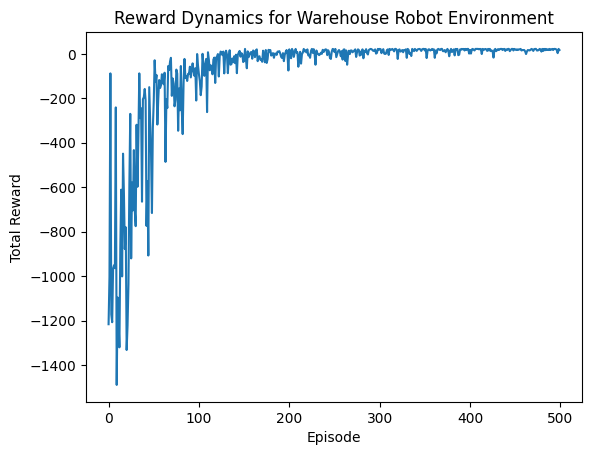

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import gymnasium as gym
from gymnasium import spaces

# Neural network for approximating Q-values with non-linearity
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

        # Add non-linearity (ReLU)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))  # Apply ReLU after first layer
        x = self.relu(self.fc2(x))  # Apply ReLU after second layer
        return self.fc3(x)  # No activation on the output layer

# Modify ReplayBuffer push method to ensure consistent data types and shapes
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def push(self, state, action, reward, next_state, done):
        
        if isinstance(state, tuple):
            state = state[0]  # Extract the state from the tuple (gym may return a tuple)

        state = np.array(state, dtype=np.float32).flatten()
        next_state = np.array(next_state, dtype=np.float32).flatten()
        # Ensure state and next_state are stored as NumPy arrays
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# DQN Agent
class DQNAgent:
    def __init__(self, state_dim, action_dim, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, lr=1e-3, batch_size=64, target_update=10):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.target_update = target_update
        self.learning_rate = lr

        # Q-network and target network
        self.q_network = QNetwork(state_dim, action_dim)
        self.target_q_network = QNetwork(state_dim, action_dim)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.MSELoss()

        # Replay buffer
        self.memory = ReplayBuffer(10000)

        # Copy parameters to the target network
        self.update_target_network()

    def update_target_network(self):
        self.target_q_network.load_state_dict(self.q_network.state_dict())
    
    def get_epsilon(self):
        return self.epsilon

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_dim - 1)
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            return self.q_network(state).argmax().item()

    def train(self):
        if len(self.memory) < self.batch_size:
            return

        # Sample a batch of transitions
        batch = self.memory.sample(self.batch_size)
        state, action, reward, next_state, done = zip(*batch)

        # Convert to appropriate tensor formats
        state = torch.FloatTensor(np.array(state))  # No need to reshape if states are consistent
        next_state = torch.FloatTensor(np.array(next_state))
        action = torch.LongTensor(action).unsqueeze(1)
        reward = torch.FloatTensor(reward)
        done = torch.FloatTensor(done)

        # Continue with the rest of the training code...
        q_values = self.q_network(state).gather(1, action).squeeze(1)
        next_q_values = self.target_q_network(next_state).max(1)[0]
        target_q_values = reward + self.gamma * next_q_values * (1 - done)

        loss = self.loss_fn(q_values, target_q_values.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def update_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

# Initialize the environment and agent
env = WarehouseRobotEnvironment(environment_type='stochastic')
state_dim = 37
action_dim = env.action_space.n

agent = DQNAgent(state_dim=state_dim, action_dim=action_dim)

reward_history = []  # To track total rewards per episode
epsilon_history = [] # To track epsilon decay

# Training the agent
num_episodes = 500
target_update_interval = 10

for episode in range(num_episodes):
    state = env.reset()  # Initial state
    total_reward = 0
    epsilon_history.append(agent.get_epsilon())

    for t in range(env.max_timesteps):
        action = agent.select_action(state)
        next_state, reward, done, truncated = env.step(action)

        # Store the transition in the replay buffer
        agent.memory.push(state, action, reward, next_state, done or truncated)

        # Train the agent
        agent.train()

        state = next_state  # Move to the next state
        total_reward += reward

        if done or truncated:
            break

    # Update epsilon (exploration-exploitation trade-off)
    agent.update_epsilon()

    # Update target network periodically
    if episode % target_update_interval == 0:
        agent.update_target_network()
    
    reward_history.append(total_reward)

    print(f"Episode {episode} - Total Reward: {total_reward}, Epsilon: {agent.epsilon}, Done: {done}, Truncated: {truncated}")

# Plot epsilon decay
plt.plot(epsilon_history)
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.title('Epsilon decay for robot Ware house environment')
plt.show()

# Plot reward dynamics
plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward Dynamics for Warehouse Robot Environment')
plt.show()


Episode 1 - Total Reward: 22
Episode 2 - Total Reward: 22
Episode 3 - Total Reward: 22
Episode 4 - Total Reward: 22
Episode 5 - Total Reward: 22


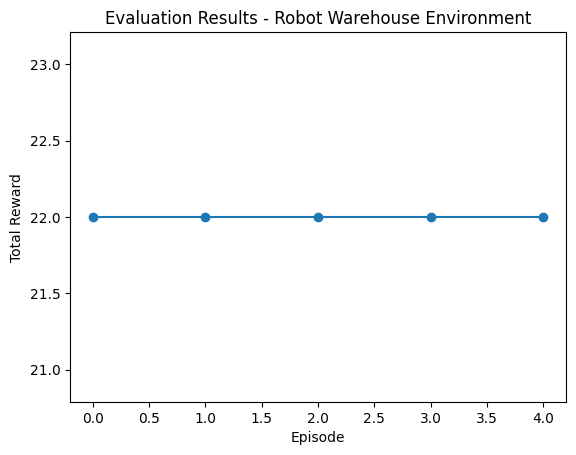

Model saved as rmora3_sudipkum_assignment2_part2_dqn_gridworld.pth


In [4]:
rewards_per_episode = []
num_episodes = 5
    
agent.epsilon = 0  # Set epsilon to 0 for greedy actions

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False
    
    while not done:
        action = agent.select_action(state)  # Greedy action
        next_state, reward, done, truncated = env.step(action)
        state = next_state
        total_reward += reward

    rewards_per_episode.append(total_reward)
    print(f"Episode {episode + 1} - Total Reward: {total_reward}")


plt.plot(rewards_per_episode, marker='o')
plt.title(f"Evaluation Results - Robot Warehouse Environment")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()

torch.save(agent.q_network.state_dict(), "rmora3_sudipkum_assignment2_part2_dqn_gridworld.pth")  # Save the learned Q-network
print(f"Model saved as rmora3_sudipkum_assignment2_part2_dqn_gridworld.pth")

In [5]:
# Initialize the CartPole-v1 environment
env = gym.make('CartPole-v1')

state_dim = env.observation_space.shape[0]  # 4-dim state space
action_dim = env.action_space.n  # 2 possible actions (left or right)

# Use the existing DQNAgent implementation
agent = DQNAgent(state_dim=state_dim, action_dim=action_dim)

Episode 0 - Total Reward: 12.0, Epsilon: 0.995, Done: True, Truncated: False
Episode 1 - Total Reward: 13.0, Epsilon: 0.990025, Done: True, Truncated: False
Episode 2 - Total Reward: 17.0, Epsilon: 0.985074875, Done: True, Truncated: False
Episode 3 - Total Reward: 31.0, Epsilon: 0.9801495006250001, Done: True, Truncated: False
Episode 4 - Total Reward: 23.0, Epsilon: 0.9752487531218751, Done: True, Truncated: False
Episode 5 - Total Reward: 36.0, Epsilon: 0.9703725093562657, Done: True, Truncated: False
Episode 6 - Total Reward: 46.0, Epsilon: 0.9655206468094844, Done: True, Truncated: False
Episode 7 - Total Reward: 14.0, Epsilon: 0.960693043575437, Done: True, Truncated: False
Episode 8 - Total Reward: 18.0, Epsilon: 0.9558895783575597, Done: True, Truncated: False
Episode 9 - Total Reward: 14.0, Epsilon: 0.9511101304657719, Done: True, Truncated: False
Episode 10 - Total Reward: 25.0, Epsilon: 0.946354579813443, Done: True, Truncated: False
Episode 11 - Total Reward: 50.0, Epsilon:

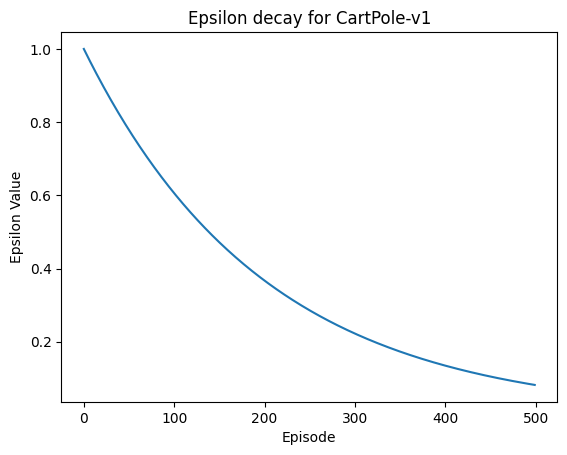

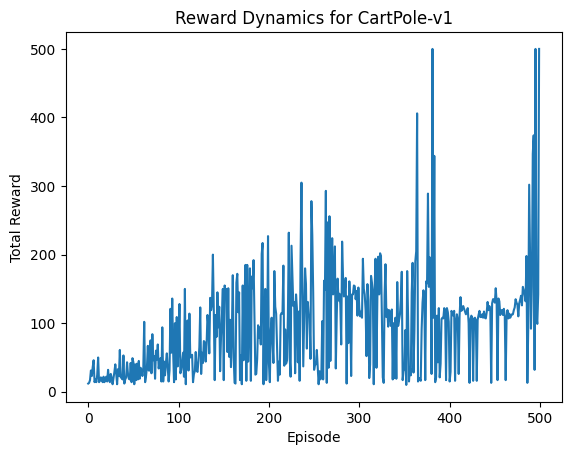

Model saved as rmora3_sudipkum_assignment2_part2_dqn_cartpole.pth


In [6]:
num_episodes = 500  # Number of episodes to train
target_update_interval = 10  # Update the target network every 10 episodes

reward_history = []  # To track total rewards per episode
epsilon_history = [] # To track epsilon decay

for episode in range(num_episodes):
    state = env.reset()  # Reset the environment
    epsilon_history.append(agent.get_epsilon())
    total_reward = 0

    for t in range(env._max_episode_steps):
        if isinstance(state, tuple):
            state = state[0]  # Extract the state from the tuple (gym may return a tuple)
        action = agent.select_action(state)
        next_state, reward, done, truncated, _ = env.step(action)

        agent.memory.push(state, action, reward, next_state, done)
        agent.train()

        state = next_state
        total_reward += reward

        if done:
            break

    # Update epsilon (exploration-exploitation trade-off)
    agent.update_epsilon()

    # Update the target network periodically
    if episode % target_update_interval == 0:
        agent.update_target_network()

    reward_history.append(total_reward)
    print(f"Episode {episode} - Total Reward: {total_reward}, Epsilon: {agent.epsilon}, Done: {done}, Truncated: {truncated}")

# Plot epsilon decay
plt.plot(epsilon_history)
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.title('Epsilon decay for CartPole-v1')
plt.show()

# Plot reward dynamics
plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward Dynamics for CartPole-v1')
plt.show()

torch.save(agent.q_network.state_dict(), "rmora3_sudipkum_assignment2_part2_dqn_cartpole.pth")  # Save the learned Q-network
print(f"Model saved as rmora3_sudipkum_assignment2_part2_dqn_cartpole.pth")



Episode 1 - Total Reward: 215.0
Episode 2 - Total Reward: 178.0
Episode 3 - Total Reward: 96.0
Episode 4 - Total Reward: 170.0
Episode 5 - Total Reward: 120.0


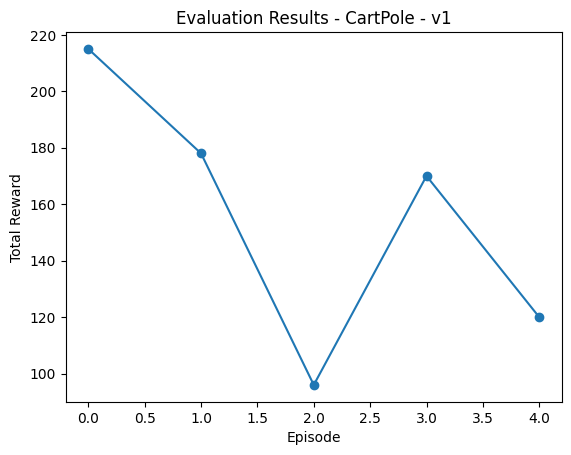

In [7]:
rewards_per_episode = []
num_episodes = 5
    
agent.epsilon = 0  # Set epsilon to 0 for greedy actions

for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False
    
    while not done:
        action = agent.select_action(state)  # Greedy action
        next_state, reward, done, truncated, _ = env.step(action)
        state = next_state
        total_reward += reward

    rewards_per_episode.append(total_reward)
    print(f"Episode {episode + 1} - Total Reward: {total_reward}")


plt.plot(rewards_per_episode, marker='o')
plt.title(f"Evaluation Results - CartPole - v1")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()

In [8]:
# Initialize the LunarLander-v2 environment
env = gym.make('LunarLander-v2')

# Get the state and action dimensions
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

reward_history = []  # To track total rewards per episode
epsilon_history = [] # To track epsilon decay

# Initialize the DQN agent
agent = DQNAgent(state_dim=state_dim, action_dim=action_dim)

# Training the agent
num_episodes = 500
target_update_interval = 10

for episode in range(num_episodes):
    state, _ = env.reset()  # Initial state
    epsilon_history.append(agent.get_epsilon())
    total_reward = 0

    for t in range(env.spec.max_episode_steps):
        action = agent.select_action(state)
        next_state, reward, done, truncated, _ = env.step(action)

        # Store the transition in the replay buffer
        agent.memory.push(state, action, reward, next_state, done)

        # Train the agent
        agent.train()

        state = next_state  # Move to the next state
        total_reward += reward

        if done or truncated:
            break

    # Update epsilon (exploration-exploitation trade-off)
    agent.update_epsilon()

    # Update target network periodically
    if episode % target_update_interval == 0:
        agent.update_target_network()
    
    reward_history.append(total_reward)

    print(f"Episode {episode} - Total Reward: {total_reward}, Epsilon: {agent.epsilon}, Done: {done}, Truncated: {truncated}")

env.close()  # Close the environment

Episode 0 - Total Reward: -89.55133056489109, Epsilon: 0.995, Done: True, Truncated: False
Episode 1 - Total Reward: -307.9445823825929, Epsilon: 0.990025, Done: True, Truncated: False
Episode 2 - Total Reward: -82.3487550596675, Epsilon: 0.985074875, Done: True, Truncated: False
Episode 3 - Total Reward: -93.02534945550408, Epsilon: 0.9801495006250001, Done: True, Truncated: False
Episode 4 - Total Reward: -110.56546106853354, Epsilon: 0.9752487531218751, Done: True, Truncated: False
Episode 5 - Total Reward: -175.20770578955216, Epsilon: 0.9703725093562657, Done: True, Truncated: False
Episode 6 - Total Reward: 5.21087463297151, Epsilon: 0.9655206468094844, Done: True, Truncated: False
Episode 7 - Total Reward: -125.48123524674332, Epsilon: 0.960693043575437, Done: True, Truncated: False
Episode 8 - Total Reward: -121.52128768517628, Epsilon: 0.9558895783575597, Done: True, Truncated: False
Episode 9 - Total Reward: -224.7019178029745, Epsilon: 0.9511101304657719, Done: True, Truncat

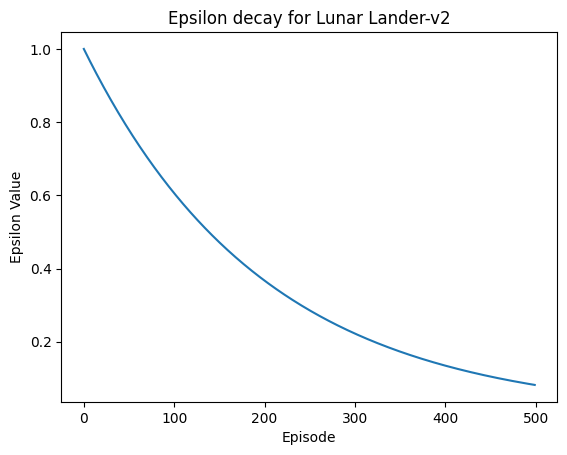

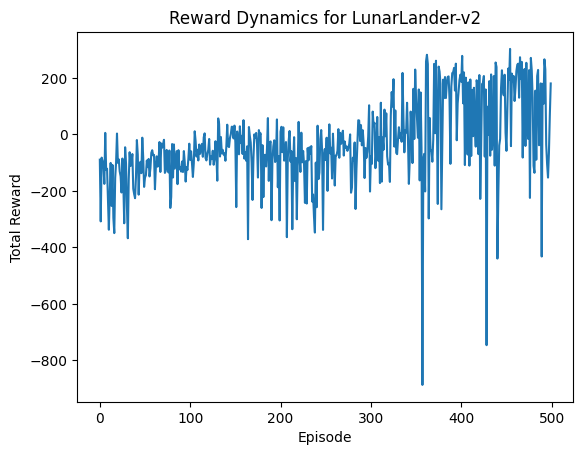

Model saved as rmora3_sudipkum_assignment2_part2_dqn_lunarlander.pth


In [9]:
# Plot epsilon decay
plt.plot(epsilon_history)
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.title('Epsilon decay for Lunar Lander-v2')
plt.show()

# Plot reward dynamics
plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward Dynamics for LunarLander-v2')
plt.show()

torch.save(agent.q_network.state_dict(), "rmora3_sudipkum_assignment2_part2_dqn_lunarlander.pth")  # Save the learned Q-network
print(f"Model saved as rmora3_sudipkum_assignment2_part2_dqn_lunarlander.pth")


Episode 1 - Total Reward: -65.2635761910613
Episode 2 - Total Reward: 203.7146596850925
Episode 3 - Total Reward: 198.27138852684436
Episode 4 - Total Reward: 105.86540713864233
Episode 5 - Total Reward: 209.7862609687348


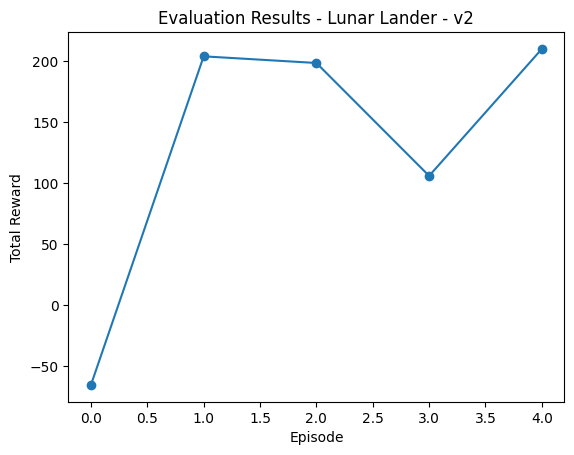

In [12]:
rewards_per_episode = []
num_episodes = 5
    
agent.epsilon = 0  # Set epsilon to 0 for greedy actions

for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False
    
    while not done:
        action = agent.select_action(state)  # Greedy action
        next_state, reward, done, truncated, _ = env.step(action)
        state = next_state
        total_reward += reward

    rewards_per_episode.append(total_reward)
    print(f"Episode {episode + 1} - Total Reward: {total_reward}")


plt.plot(rewards_per_episode, marker='o')
plt.title(f"Evaluation Results - Lunar Lander - v2")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()